In [137]:
#Environment setup
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
#libraries loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [138]:
data_rvn = pd.read_csv("RVN-USD.csv")# Data loading


data_rvn.head()#data viewing

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2018-03-10,0.026499,0.028772,0.026063,0.028618,0.028618,171820,rvn_usd
1,2018-03-11,0.028520,0.033503,0.026241,0.031883,0.031883,279104,rvn_usd
2,2018-03-12,0.031496,0.034305,0.028595,0.030258,0.030258,218114,rvn_usd
3,2018-03-13,0.029902,0.030913,0.025711,0.027902,0.027902,167669,rvn_usd
4,2018-03-14,0.027723,0.028685,0.023747,0.024386,0.024386,131838,rvn_usd


In [139]:
data_rvn['Close'].value_counts() 

0.014633    4
0.012732    3
0.016562    2
0.033911    2
0.020475    2
           ..
0.030286    1
0.031080    1
0.029408    1
0.030773    1
0.021712    1
Name: Close, Length: 1688, dtype: int64

In [140]:
df = data_rvn.loc[(data_rvn['key'] == 'rvn_usd')]
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2018-03-10,0.026499,0.028772,0.026063,0.028618,0.028618,171820,rvn_usd
1,2018-03-11,0.028520,0.033503,0.026241,0.031883,0.031883,279104,rvn_usd
2,2018-03-12,0.031496,0.034305,0.028595,0.030258,0.030258,218114,rvn_usd
3,2018-03-13,0.029902,0.030913,0.025711,0.027902,0.027902,167669,rvn_usd
4,2018-03-14,0.027723,0.028685,0.023747,0.024386,0.024386,131838,rvn_usd
5,2018-03-15,0.024375,0.024720,0.021852,0.024465,0.024465,114232,rvn_usd
6,2018-03-16,0.024451,0.026424,0.018755,0.024532,0.024532,121884,rvn_usd
7,2018-03-17,0.024572,0.024924,0.021598,0.022769,0.022769,108011,rvn_usd
8,2018-03-18,0.022634,0.023218,0.017096,0.022619,0.022619,141594,rvn_usd
9,2018-03-19,0.022523,0.024033,0.020037,0.021576,0.021576,91701,rvn_usd


In [141]:
#date time collection
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > pd.to_datetime('2017-11-09')]

In [142]:
df = df[['Date','Open','Close','High','Low','Volume']]

In [143]:
df.head()

,Date,Open,Close,High,Low,Volume
0,2018-03-10,0.026499,0.028618,0.028772,0.026063,171820
1,2018-03-11,0.028520,0.031883,0.033503,0.026241,279104
2,2018-03-12,0.031496,0.030258,0.034305,0.028595,218114
3,2018-03-13,0.029902,0.027902,0.030913,0.025711,167669
4,2018-03-14,0.027723,0.024386,0.028685,0.023747,131838


In [144]:
df = df[['Close']]

In [145]:
dataset = df.values
dataset = dataset.astype('float32')

In [146]:
dataset

array([[0.028618],
       [0.031883],
       [0.030258],
       ...,
       [0.021459],
       [0.021671],
       [0.021712]], dtype=float32)

In [147]:
#Rescaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scale = scaler.fit_transform(dataset)

In [148]:
dataset_scale

array([[0.08241345],
       [0.09686458],
       [0.08967221],
       ...,
       [0.0507272 ],
       [0.05166553],
       [0.051847  ]], dtype=float32)

In [149]:
#training set size
train_size = int(len(dataset_scale) * 0.709)
test_size = len(dataset_scale) - train_size
train, test = dataset_scale[0:train_size, :], dataset_scale[train_size:len(dataset), :]
print(len(train), len(test))

1217 500


In [150]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [151]:
look_back = 20
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [152]:
trainX
trainY
#testX
#testY

array([0.14176263, 0.14627722, 0.13322474, ..., 0.18908176, 0.19329537,
       0.19198968], dtype=float32)

In [153]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [154]:
#Model set-up
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adamax')
model.fit(trainX, trainY, epochs=750, batch_size=370, verbose=2)

Epoch 1/750
4/4 - 1s - loss: 0.0428 - 767ms/epoch - 192ms/step
Epoch 2/750
4/4 - 0s - loss: 0.0390 - 7ms/epoch - 2ms/step
Epoch 3/750
4/4 - 0s - loss: 0.0356 - 8ms/epoch - 2ms/step
Epoch 4/750
4/4 - 0s - loss: 0.0330 - 7ms/epoch - 2ms/step
Epoch 5/750
4/4 - 0s - loss: 0.0304 - 6ms/epoch - 2ms/step
Epoch 6/750
4/4 - 0s - loss: 0.0283 - 8ms/epoch - 2ms/step
Epoch 7/750
4/4 - 0s - loss: 0.0266 - 6ms/epoch - 2ms/step
Epoch 8/750
4/4 - 0s - loss: 0.0251 - 8ms/epoch - 2ms/step
Epoch 9/750
4/4 - 0s - loss: 0.0238 - 6ms/epoch - 2ms/step
Epoch 10/750
4/4 - 0s - loss: 0.0227 - 7ms/epoch - 2ms/step
Epoch 11/750
4/4 - 0s - loss: 0.0216 - 7ms/epoch - 2ms/step
Epoch 12/750
4/4 - 0s - loss: 0.0207 - 8ms/epoch - 2ms/step
Epoch 13/750
4/4 - 0s - loss: 0.0198 - 7ms/epoch - 2ms/step
Epoch 14/750
4/4 - 0s - loss: 0.0190 - 8ms/epoch - 2ms/step
Epoch 15/750
4/4 - 0s - loss: 0.0181 - 7ms/epoch - 2ms/step
Epoch 16/750
4/4 - 0s - loss: 0.0173 - 7ms/epoch - 2ms/step
Epoch 17/750
4/4 - 0s - loss: 0.0166 - 7ms/ep

4/4 - 0s - loss: 0.0029 - 8ms/epoch - 2ms/step
Epoch 138/750
4/4 - 0s - loss: 0.0029 - 7ms/epoch - 2ms/step
Epoch 139/750
4/4 - 0s - loss: 0.0029 - 8ms/epoch - 2ms/step
Epoch 140/750
4/4 - 0s - loss: 0.0029 - 7ms/epoch - 2ms/step
Epoch 141/750
4/4 - 0s - loss: 0.0029 - 8ms/epoch - 2ms/step
Epoch 142/750
4/4 - 0s - loss: 0.0029 - 7ms/epoch - 2ms/step
Epoch 143/750
4/4 - 0s - loss: 0.0028 - 8ms/epoch - 2ms/step
Epoch 144/750
4/4 - 0s - loss: 0.0028 - 7ms/epoch - 2ms/step
Epoch 145/750
4/4 - 0s - loss: 0.0028 - 7ms/epoch - 2ms/step
Epoch 146/750
4/4 - 0s - loss: 0.0028 - 7ms/epoch - 2ms/step
Epoch 147/750
4/4 - 0s - loss: 0.0028 - 8ms/epoch - 2ms/step
Epoch 148/750
4/4 - 0s - loss: 0.0028 - 7ms/epoch - 2ms/step
Epoch 149/750
4/4 - 0s - loss: 0.0027 - 8ms/epoch - 2ms/step
Epoch 150/750
4/4 - 0s - loss: 0.0027 - 7ms/epoch - 2ms/step
Epoch 151/750
4/4 - 0s - loss: 0.0027 - 7ms/epoch - 2ms/step
Epoch 152/750
4/4 - 0s - loss: 0.0027 - 7ms/epoch - 2ms/step
Epoch 153/750
4/4 - 0s - loss: 0.0027 

Epoch 272/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 273/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 274/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 275/750
4/4 - 0s - loss: 0.0017 - 8ms/epoch - 2ms/step
Epoch 276/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 277/750
4/4 - 0s - loss: 0.0017 - 8ms/epoch - 2ms/step
Epoch 278/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 279/750
4/4 - 0s - loss: 0.0017 - 8ms/epoch - 2ms/step
Epoch 280/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 281/750
4/4 - 0s - loss: 0.0017 - 8ms/epoch - 2ms/step
Epoch 282/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 283/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 284/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 285/750
4/4 - 0s - loss: 0.0017 - 8ms/epoch - 2ms/step
Epoch 286/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 287/750
4/4 - 0s - loss: 0.0017 - 7ms/epoch - 2ms/step
Epoch 288/750
4/4 - 0s -

Epoch 407/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 408/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 409/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 410/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 411/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 412/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 413/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 414/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 415/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 416/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 417/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 418/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 419/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 420/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 421/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 422/750
4/4 - 0s - loss: 0.0012 - 7ms/epoch - 2ms/step
Epoch 423/750
4/4 - 0s -

Epoch 539/750
4/4 - 0s - loss: 9.3074e-04 - 7ms/epoch - 2ms/step
Epoch 540/750
4/4 - 0s - loss: 9.3850e-04 - 7ms/epoch - 2ms/step
Epoch 541/750
4/4 - 0s - loss: 9.3617e-04 - 7ms/epoch - 2ms/step
Epoch 542/750
4/4 - 0s - loss: 9.3169e-04 - 8ms/epoch - 2ms/step
Epoch 543/750
4/4 - 0s - loss: 9.2902e-04 - 7ms/epoch - 2ms/step
Epoch 544/750
4/4 - 0s - loss: 9.2800e-04 - 7ms/epoch - 2ms/step
Epoch 545/750
4/4 - 0s - loss: 9.2561e-04 - 7ms/epoch - 2ms/step
Epoch 546/750
4/4 - 0s - loss: 9.2437e-04 - 8ms/epoch - 2ms/step
Epoch 547/750
4/4 - 0s - loss: 9.2331e-04 - 7ms/epoch - 2ms/step
Epoch 548/750
4/4 - 0s - loss: 9.2224e-04 - 7ms/epoch - 2ms/step
Epoch 549/750
4/4 - 0s - loss: 9.1999e-04 - 7ms/epoch - 2ms/step
Epoch 550/750
4/4 - 0s - loss: 9.1845e-04 - 7ms/epoch - 2ms/step
Epoch 551/750
4/4 - 0s - loss: 9.1802e-04 - 7ms/epoch - 2ms/step
Epoch 552/750
4/4 - 0s - loss: 9.1599e-04 - 7ms/epoch - 2ms/step
Epoch 553/750
4/4 - 0s - loss: 9.1490e-04 - 7ms/epoch - 2ms/step
Epoch 554/750
4/4 - 0s - 

4/4 - 0s - loss: 8.0308e-04 - 7ms/epoch - 2ms/step
Epoch 666/750
4/4 - 0s - loss: 8.0346e-04 - 7ms/epoch - 2ms/step
Epoch 667/750
4/4 - 0s - loss: 8.0317e-04 - 7ms/epoch - 2ms/step
Epoch 668/750
4/4 - 0s - loss: 8.0044e-04 - 7ms/epoch - 2ms/step
Epoch 669/750
4/4 - 0s - loss: 7.9979e-04 - 7ms/epoch - 2ms/step
Epoch 670/750
4/4 - 0s - loss: 7.9805e-04 - 7ms/epoch - 2ms/step
Epoch 671/750
4/4 - 0s - loss: 7.9847e-04 - 7ms/epoch - 2ms/step
Epoch 672/750
4/4 - 0s - loss: 7.9704e-04 - 7ms/epoch - 2ms/step
Epoch 673/750
4/4 - 0s - loss: 7.9596e-04 - 7ms/epoch - 2ms/step
Epoch 674/750
4/4 - 0s - loss: 7.9560e-04 - 6ms/epoch - 2ms/step
Epoch 675/750
4/4 - 0s - loss: 7.9613e-04 - 7ms/epoch - 2ms/step
Epoch 676/750
4/4 - 0s - loss: 7.9547e-04 - 7ms/epoch - 2ms/step
Epoch 677/750
4/4 - 0s - loss: 7.9340e-04 - 8ms/epoch - 2ms/step
Epoch 678/750
4/4 - 0s - loss: 7.9238e-04 - 7ms/epoch - 2ms/step
Epoch 679/750
4/4 - 0s - loss: 7.9240e-04 - 7ms/epoch - 2ms/step
Epoch 680/750
4/4 - 0s - loss: 7.9168e-

In [155]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

15/15 [==============================] - 0s 813us/step


In [156]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [157]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


In [158]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [159]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

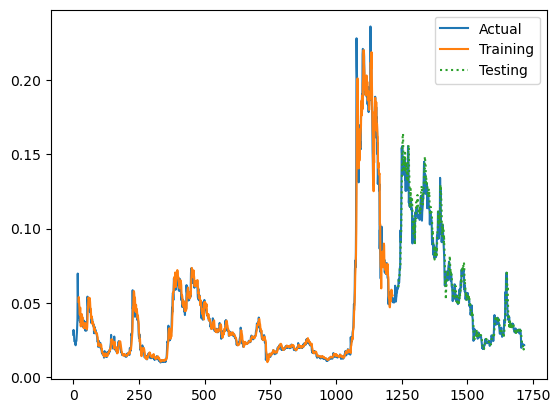

In [162]:
plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing',linestyle='dotted')
plt.legend(loc='best')
plt.show()

In [161]:
from sklearn.metrics import mean_squared_error

mean_squared_error(testY[0].reshape(-1),testPredict[:, 0])



4.733607361778611e-05

In [163]:
    from keras.models import load_model
    model.save('rvn-adam.h5') 
    model.save_weights('adam_weights.h5')  # to store